# Phast - 3D Cloud
Traditionally, dispersion results are displayed in 2D graphs. With the Phast APIs, we can easily vary the height of interest to visualise a three dimensional cloud.

## Import the required items

In [24]:
import {
  VesselStateCalculation,
  VesselLeakCalculation
} from "./src/calculations/discharge";

import { DispersionCalculation } from "./src/calculations/dispersion";

import { MixtureConstantPropertiesCalculation } from "./src/calculations/applicationTools";

import { DistancesAndFootprintsToConcentrationLevelsCalculation } from "./src/calculations/dispersionView";

import {
  State,
  Material,
  MaterialComponent,
  Vessel,
  Leak,
  DischargeParameters,
  DispersionParameters,
  Weather,
  Substrate,
  DispersionOutputConfig,
  LocalPosition,
} from "./src/entities";

import {
  ResultCode,
  FluidSpec,
  MixtureModelling,
  SpecialConcentration,
} from "./src/enums";

import { setAccessToken } from "./src/utilities";
import { getMaterialByName } from "./src/materials";
import Plotly from "tslab-plotly";
import * as tslab from "tslab";

// Set up access token
const accessToken = process.env.PWS_ACCESS_TOKEN;
if (!accessToken) {
  throw new Error("PWS_ACCESS_TOKEN environment variable is not set.");
}
setAccessToken(accessToken);


## Running discharge calculations

### Calculate the vessel conditions
Define the input data and determine the vessel conditions...

In [25]:
const material = await getMaterialByName("HYDROGEN");
const pressure = 20000000;
const temperature = 293.15;
const holeDiameter = 0.02;

const state = new State({
  pressure: pressure,
  temperature: temperature,
  liquidFraction: 0,
  flashFlag: FluidSpec.TP,
  mixtureModelling: MixtureModelling.PC
});

const vesselStateCalculation = new VesselStateCalculation(material, state);

const resultCode = await vesselStateCalculation.run();

if (resultCode === ResultCode.SUCCESS) {
    console.log("Vessel state calculation successful.");
    console.log("The vessel conditions are " + vesselStateCalculation.vesselConditions);
    
    var vesselConditions = vesselStateCalculation.vesselConditions;
} else {
    console.log("Vessel state calculation failed.");
}

Vessel state calculation successful.
The vessel conditions are 1


### Calculate the discharge
Use the VesselLeakCalculation class to model the discharge...

In [26]:
const vessel = new Vessel({
  state: state,
  material: material,
  liquidFillFractionByVolume: 0,
  vesselConditions: vesselStateCalculation.vesselConditions
});

const leak = new Leak({
  holeDiameter: holeDiameter
});

const dischargeParameters = new DischargeParameters();

const vesselLeakCalculation = new VesselLeakCalculation(
  vessel,
  leak,
  dischargeParameters
);

const resultCode2 = await vesselLeakCalculation.run();

if (resultCode2 === ResultCode.SUCCESS) {
    console.log("Discharge calculations successful.");
} else {
    console.log("Discharge calculations failed.");
}

Discharge calculations successful.


### Review the discharge results
In this scenario, the Leak uses the default INITIAL_RATE for the timeVaryingOption. In other words, the leak is a constant discharge at the maximum discharge rate.

In [27]:
for (const record of vesselLeakCalculation.dischargeRecords!) {
    console.log(`Time: ${record.time.toFixed(2)} s, Mass flow: ${record.massFlow.toFixed(2)} kg/s`);
}

Time: 0.00 s, Mass flow: 3.27 kg/s
Time: 55.45 s, Mass flow: 3.27 kg/s


## Running dispersion calculations

### Calculate the dispersion
We can pass the discharge results into a DispersionCalculation...

In [28]:
const weather = new Weather({
  windSpeed: 5
});

const substrate = new Substrate();
const dispersionCalculations: DispersionCalculation[] = [];
const endPointConcentration = 0.0;
const dispersionParameters = new DispersionParameters();

const dispersionCalculation = new DispersionCalculation(
  vesselLeakCalculation.exitMaterial!,
  substrate,
  vesselLeakCalculation.dischargeResult!,
  vesselLeakCalculation.dischargeRecords!,
  vesselLeakCalculation.dischargeRecords!.length,
  weather,
  dispersionParameters,
  endPointConcentration
);

const resultCode3 = await dispersionCalculation.run();

if (resultCode3 === ResultCode.SUCCESS) {
    console.log("Dispersion calculations successful.");
} else {
    console.log("Dispersion calculations failed.");
}

Dispersion calculations successful.


## Running post-processing calculations

### Calculate distances and footprints to concentration levels
The DispersionCalculation returns raw dispersion results which need to be post-processed. For this we can use the DistancesAndFootprintsToConcentrationLevelsCalculation class to generate contour points on an XY plane.

This calculation requires a list of DispersionOutputConfig. This is normally reserved for situations where there are multiple concentrations of interest, one per output config. Although the output config has an elevation property, which is the height of interest for the footprint, at the time of writing the API does not support varying the elevation in a single calculation.

Thus, we run one DistancesAndFootprintsToConcentrationLevelsCalculation per heightOfInterest.

In [29]:
const heightsOfInterest = [0, 1, 2, 3, 4, 5, 6];
const footprintCalculations: DistancesAndFootprintsToConcentrationLevelsCalculation[] = [];

for (const heightOfInterest of heightsOfInterest) {
    const footprintCalculation = new DistancesAndFootprintsToConcentrationLevelsCalculation(
        dispersionCalculation.scalarUdmOutputs!,
        weather,
        dispersionCalculation.dispersionRecords!,
        dispersionCalculation.dispersionRecords!.length,
        substrate,
        [new DispersionOutputConfig({
            elevation: heightOfInterest,
            specialConcentration: SpecialConcentration.LFL
        })],
        1,
        dispersionParameters,
        vesselLeakCalculation.exitMaterial!
    );

    const resultCode4 = await footprintCalculation.run();

    if (resultCode4 === ResultCode.SUCCESS) {
        console.log(`Footprint calculations successful for ${heightOfInterest} m height.`);
        footprintCalculations.push(footprintCalculation);
    } else {
        console.log("Footprint calculations failed.");
    }
}

Footprint calculations successful for 0 m height.
Footprint calculations successful for 1 m height.
Footprint calculations successful for 2 m height.
Footprint calculations successful for 3 m height.
Footprint calculations successful for 4 m height.
Footprint calculations successful for 5 m height.
Footprint calculations successful for 6 m height.


## Review the results

The DistancesAndFootprintsToConcentrationLevelsCalculation provides XY contour points for a specific concentration. In this case, we used the SpecialConcentration.LFL option. Let's check this...

In [30]:
for (const footprintCalculation of footprintCalculations) {
    console.log(`The concentration fraction used in the footprint calculation for a height of ${footprintCalculation.dispersionOutputConfigs[0].elevation} is [${footprintCalculation.concsUsed}]`);
}

const constantMixtureProperties = new MixtureConstantPropertiesCalculation(material);

const resultCode5 = await constantMixtureProperties.run();

if (resultCode5 === ResultCode.SUCCESS) {
    const lfl = constantMixtureProperties.mixConstantPropResult!.lowerFlammabilityLimit;
    console.log(`This compares to an LFL for hydrogen equal to ${lfl}, ` +
          `which is equivalent to ${lfl * 1000000} ppm.`);
} else {
    console.log("Mixture properties calculations failed.");
}

The concentration fraction used in the footprint calculation for a height of 0 is [0.04]
The concentration fraction used in the footprint calculation for a height of 1 is [0.04]
The concentration fraction used in the footprint calculation for a height of 2 is [0.04]
The concentration fraction used in the footprint calculation for a height of 3 is [0.04]
The concentration fraction used in the footprint calculation for a height of 4 is [0.04]
The concentration fraction used in the footprint calculation for a height of 5 is [0.04]
The concentration fraction used in the footprint calculation for a height of 6 is [0.04]
This compares to an LFL for hydrogen equal to 0.04, which is equivalent to 40000 ppm.


The DistancesAndFootprintsToConcentrationLevelsCalculation object has a distancesConcentration property which provides us with the downwind distance to the concentration used in the calculation.

In [31]:
for (const footprintCalculation of footprintCalculations) {
    const distance = footprintCalculation.distancesConcentration![0];
    console.log(`The downwind distance to a concentration fraction of ${footprintCalculation.concsUsed![0]} is ${distance.toFixed(2)} m.`);
}

The downwind distance to a concentration fraction of 0.04 is 52.97 m.
The downwind distance to a concentration fraction of 0.04 is 59.20 m.
The downwind distance to a concentration fraction of 0.04 is 63.54 m.
The downwind distance to a concentration fraction of 0.04 is 66.35 m.
The downwind distance to a concentration fraction of 0.04 is 67.23 m.
The downwind distance to a concentration fraction of 0.04 is 65.23 m.
The downwind distance to a concentration fraction of 0.04 is -9.95e+36 m.


## Plot the contour points

The DistancesAndFootprintsToConcentrationLevelsCalculation object has a contourPoints property. This is a list of LocalPosition, which itself has x, y and z properties.

**Note:** The ncontourPoints property contains the number of graphing points per DispersionOutputConfig, and contourPoints is an array of all graphing points for all DispersionOutputConfigs, where the order of the graphing points is the same order in which the DispersionOutputConfigs were provided. For example, if you defined three output configs for concentration levels ordered as LFL, LFLFraction and UFL, the contourPoints array will contain the graphing points for LFL, LFLFraction and UFL in the same order.

Unlike contour data for radiation, the number of contour points for each scenario is not always the same.

Let's extract and display the 3D data...

In [32]:
// MDE value check - threshold value returned from the model development environment
const mdeValueCheck = -9.9E+36; // -9.95E+36 is a threshold value to signify that there is no result

// Extract x, y, z values from all footprint calculations
const xValues: number[] = [];
const yValues: number[] = [];
const zValues: number[] = [];

for (const calculation of footprintCalculations) {
    for (const point of calculation.contourPoints!) {
        if (point.x > mdeValueCheck) {
            xValues.push(point.x);
            yValues.push(point.y);
            zValues.push(point.z);
        }
    }
}

console.log(`Total valid contour points: ${xValues.length}`);
console.log(`X range: ${Math.min(...xValues).toFixed(2)} to ${Math.max(...xValues).toFixed(2)} m`);
console.log(`Y range: ${Math.min(...yValues).toFixed(2)} to ${Math.max(...yValues).toFixed(2)} m`);
console.log(`Z range: ${Math.min(...zValues).toFixed(2)} to ${Math.max(...zValues).toFixed(2)} m`);

// Export data for visualization (can be imported into plotting libraries)
const plotData = {
    x: xValues,
    y: yValues,
    z: zValues,
    type: '3D Cloud Contour Points',
    concentration: 'LFL (Lower Flammability Limit)',
    material: 'Hydrogen'
};

console.log("3D cloud data prepared for visualization:");
//console.log(JSON.stringify(plotData, null, 2));

Total valid contour points: 3212
X range: -0.10 to 67.23 m
Y range: -3.12 to 3.12 m
Z range: 0.00 to 5.00 m
3D cloud data prepared for visualization:


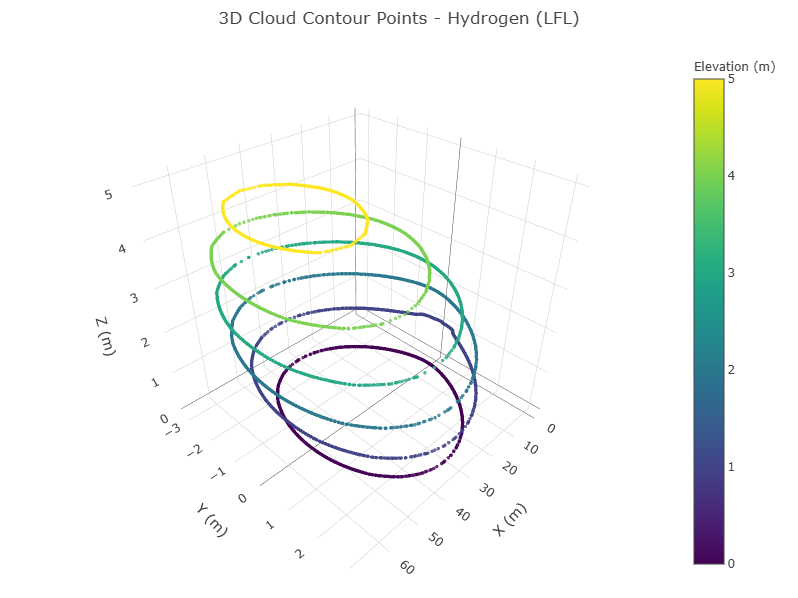

In [33]:
// MDE value check
const mdeValueCheck = -9.9E+36;

const xValues: number[] = [];
const yValues: number[] = [];
const zValues: number[] = [];

for (const calculation of footprintCalculations) {
    for (const point of calculation.contourPoints!) {
        if (point.x > mdeValueCheck) {
            xValues.push(point.x);
            yValues.push(point.y);
            zValues.push(point.z);
        }
    }
}

// Plotting
Plotly.newPlot(tslab, [{
    type: "scatter3d",
    mode: "markers",
    x: xValues,
    y: yValues,
    z: zValues,
    marker: {
        size: 2,
        color: zValues,
        colorscale: "Viridis",
        opacity: 0.8,
        colorbar: {
            title: "Elevation (m)"
        }
    }
}], {
    title: "3D Cloud Contour Points - Hydrogen (LFL)",
    scene: {
        xaxis: { title: "X (m)" },
        yaxis: { title: "Y (m)" },
        zaxis: { title: "Z (m)" }
    },
    width: 800,
    height: 600
});